In [1]:
library(knitr)
library(rmdformats)
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(formattable)
library(IRdisplay) # displays tables when in ipynb format

library(xgboost)
library(tidymodels)
#library(SHAPforxgboost)


source("./Baudry_functions_v2.R")


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp


-- Attaching packages ------------------------------------------------------------------------------ tidymodels 1.1.0 --

v broom        1.0.5     v rsample      1.1.1
v dials        1.2.0     v tibble       3.2.1
v dplyr        1.1.4     v tidyr        1.3.1
v infer        1.0.4     v tune         1.1.1
v modeldata    1.1.0     v workflows    1.1.3
v parsnip      1.1.0     v workflowsets 1.0.1
v purrr        1.0.2     v yardstick    1.3.1
v recipes      1.0.6     

-- Conflicts --------------------------------------------------------------------------------- tidymodels_conflicts() --
x dplyr::between()    masks data

In [2]:
dt_PhoneData <- simulate_central_scenario(1234)


In [3]:


dt_polclaim <- join_policy_claim(dt_PhoneData,
                                 date_pol_start = "date_UW",
                                 date_pol_end = "date_lapse",
                                 date_occur = "date_occur")


In [4]:

lst_Date_slice <- floor_date(seq(as.Date("2008/1/1"), as.Date("2024/12/31"), by = 180), unit= "second") 
dt_polclaim <- time_slice_polclaim(dt_polclaim, lst_Date_slice)

In [5]:
head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,...,P_t_20200427,P_t_20201024,P_t_20210422,P_t_20211019,P_t_20220417,P_t_20221014,P_t_20230412,P_t_20231009,P_t_20240406,P_t_20241003
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200801010001,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2008-01-01,...,0,0,0,0,0,0,0,0,0,0
200801010002,201008260001,B,1,0.2424128,2008-10-20 00:00:00,2010-08-26 00:00:00,2012-09-07 00:00:00,221,2008-01-01,...,221,221,221,221,221,221,221,221,221,221
200801010003,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2008-01-01,...,0,0,0,0,0,0,0,0,0,0
200801010004,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2008-01-01,...,0,0,0,0,0,0,0,0,0,0
200801010005,201004280001,B,1,0.1973073,2008-06-23 00:00:00,2010-04-28 00:00:00,2012-04-17 00:00:00,180,2008-01-01,...,180,180,180,180,180,180,180,180,180,180
200801010006,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2008-01-01,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Convert columns to Date format if not already
dt_polclaim$date_occur <- as.Date(dt_polclaim$date_occur)
dt_polclaim$date_report <- as.Date(dt_polclaim$date_report)
dt_polclaim$date_pay <- as.Date(dt_polclaim$date_pay)
dt_polclaim$date_pol_start <- as.Date(dt_polclaim$date_pol_start)

# Filter out rows where any of the dates are '2199-12-31'
dt_polclaim <- dt_polclaim[!(date_occur == "2199-12-31" | date_report == "2199-12-31" | date_pay == "2199-12-31")]

# Calculate the delays
dt_polclaim[, occ_delay := as.numeric(difftime(date_occur, date_pol_start, units = "days"))]
dt_polclaim[, report_delay := as.numeric(difftime(date_report, date_occur, units = "days"))]
dt_polclaim[, pay_delay := as.numeric(difftime(date_pay, date_report, units = "days"))]

# Calculate the statistics (max, min, mean, median) for each delay
delay_stats <- matrix(nrow = 4, ncol = 3, 
                     dimnames = list(c("Max", "Min", "Mean", "Median"), 
                                     c("Occurrence Delay", "Report Delay", "Payment Delay")))

# Filling the matrix with values
delay_stats["Max", "Occurrence Delay"] <- max(dt_polclaim$occ_delay, na.rm = TRUE)
delay_stats["Min", "Occurrence Delay"] <- min(dt_polclaim$occ_delay, na.rm = TRUE)
delay_stats["Mean", "Occurrence Delay"] <- mean(dt_polclaim$occ_delay, na.rm = TRUE)
delay_stats["Median", "Occurrence Delay"] <- median(dt_polclaim$occ_delay, na.rm = TRUE)

delay_stats["Max", "Report Delay"] <- max(dt_polclaim$report_delay, na.rm = TRUE)
delay_stats["Min", "Report Delay"] <- min(dt_polclaim$report_delay, na.rm = TRUE)
delay_stats["Mean", "Report Delay"] <- mean(dt_polclaim$report_delay, na.rm = TRUE)
delay_stats["Median", "Report Delay"] <- median(dt_polclaim$report_delay, na.rm = TRUE)

delay_stats["Max", "Payment Delay"] <- max(dt_polclaim$pay_delay, na.rm = TRUE)
delay_stats["Min", "Payment Delay"] <- min(dt_polclaim$pay_delay, na.rm = TRUE)
delay_stats["Mean", "Payment Delay"] <- mean(dt_polclaim$pay_delay, na.rm = TRUE)
delay_stats["Median", "Payment Delay"] <- median(dt_polclaim$pay_delay, na.rm = TRUE)

# Print the matrix
print(delay_stats)


       Occurrence Delay Report Delay Payment Delay
Max            365.0000     912.0000      912.0000
Min              0.0000     376.0000      405.0000
Mean           178.5693     729.7584      733.3302
Median         176.0000     725.0000      730.0000


In [7]:
# Define the start and end dates
start_date <- as.Date("2008-01-01")
end_date <- as.Date("2024-12-31")

# Create a sequence of dates for every 180 days
slices <- seq(start_date, end_date, by = "180 days")

# Print the extracted dates from "P_t_YYYYMMDD" format
for (i in 1:length(slices)) {
  date_str <- format(slices[i], "%Y%m%d")
  print(as.Date(date_str, format="%Y%m%d"))
}


[1] "2008-01-01"
[1] "2008-06-29"
[1] "2008-12-26"
[1] "2009-06-24"
[1] "2009-12-21"
[1] "2010-06-19"
[1] "2010-12-16"
[1] "2011-06-14"
[1] "2011-12-11"
[1] "2012-06-08"
[1] "2012-12-05"
[1] "2013-06-03"
[1] "2013-11-30"
[1] "2014-05-29"
[1] "2014-11-25"
[1] "2015-05-24"
[1] "2015-11-20"
[1] "2016-05-18"
[1] "2016-11-14"
[1] "2017-05-13"
[1] "2017-11-09"
[1] "2018-05-08"
[1] "2018-11-04"
[1] "2019-05-03"
[1] "2019-10-30"
[1] "2020-04-27"
[1] "2020-10-24"
[1] "2021-04-22"
[1] "2021-10-19"
[1] "2022-04-17"
[1] "2022-10-14"
[1] "2023-04-12"
[1] "2023-10-09"
[1] "2024-04-06"
[1] "2024-10-03"


In [8]:
# Set valuation date to the 13th slice
i <- valuation <- 15

# Get the valuation date (13th slice)
t_i <- lst_Date_slice[i]

# Calculate delta (distance to the nearest end of the slice sequence)
delta <- min(i, length(lst_Date_slice) - i + 1)

# Print the results
print(paste("Valuation Date (t_i):", t_i))
print(paste("Delta:", delta))


[1] "Valuation Date (t_i): 2014-11-25"
[1] "Delta: 15"


In [9]:
RBNS_Train_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars) {

  date_i <- as.Date(date_i)
  
  date_k <- (reserving_dates[which(reserving_dates == date_i) - k + 1])
  date_j <- (reserving_dates[which(reserving_dates == date_k) - j_dev_period])
  
  date_lookup <- (reserving_dates[which(reserving_dates == date_i) - j_dev_period - k + 1])
  target_lookup <- (reserving_dates[which(reserving_dates == date_i) - k])
  target_lookup_next <- (reserving_dates[which(reserving_dates == date_i) - k + 1])

  dt_policy_claim <- dt_policy_claim[(date_report <= date_lookup) & (date_pay > date_lookup)]

  dt_policy_claim[, ':='(
    date_lookup = date_lookup,
    delay_train = as.numeric(date_lookup - date_pol_start), # Delay between policy start and date_lookup
    j = j_dev_period,  # Dev period J
    k = k,  # Model type K
    target = ifelse(date_pay <= target_lookup, 0, ifelse(date_pay <= target_lookup_next, claim_cost, 0))
  )]
  
  # Calculate premium and loss for the training set (Aggregated by year)
  dt_policy_claim[, Premium := sum(Price), by = year(date_pol_start)]  # Total premium per year
  dt_policy_claim[, Loss := sum(claim_cost), by = year(date_pol_start)]  # Total loss per year
  
  # Calculate loss ratio for the training data: Loss ratio = Loss / Premium
  dt_policy_claim[, Loss_Ratio := Loss / Premium]

  # Returning the necessary columns for model training
  return(dt_policy_claim[, model_vars, with = FALSE])
}


In [10]:
RBNS_Test_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars) {
  
  # Convert date_i (valuation date) and end_date to Date format
  date_i <- as.Date(date_i)
  end_date <- as.Date("2018-11-04")  # End date for test data
  
  # Filter the test data to include only claims where date_report is between date_i and end_date
  dt_test <- dt_policy_claim[date_report >= date_i & date_report <= end_date]
  
  # Date adjustments based on dev period and k (same logic as before)
  date_lookup_test <- end_date  # Set the date_lookup_test to the end date (2018-12-31)
  
  # Calculate the target lookups based on the end date
  target_lookup_end <- (reserving_dates[which(reserving_dates == date_lookup_test) + j_dev_period - 1])
  target_lookup_end_next <- (reserving_dates[which(reserving_dates == date_lookup_test) + j_dev_period])
  
  # Filter for RBNS claims: Reported but not settled (i.e., date_report <= date_lookup_test and date_lookup_test < date_pay)
  dt_test <- dt_test[date_report <= date_lookup_test & date_lookup_test < date_pay]
  
  # Add necessary columns for model testing
  dt_test[, ':='(
    date_lookup_test = date_lookup_test,  # Use end date as lookup date
    delay_train = as.numeric(date_lookup_test - date_pol_start),  # Delay between policy start and date_lookup_test
    j = j_dev_period,  # Development period
    k = k,  # Model type (fixed)
    target = ifelse(date_pay <= target_lookup_end, 0, ifelse(date_pay <= target_lookup_end_next, claim_cost, 0))  # Adjust target calculation based on end date lookups
  )]

    dt_test[is.na(target), target := 0]
  
  # Return the dataset with selected model variables for prediction
  return(dt_test[, model_vars, with = FALSE])
}


In [11]:

RBNS_Train <- function(dt_policy_claim, date_i, i, k, reserving_dates, model_vars) {
# Create a combined TRAIN dataset across all k and j combos
  for (k in 1:k){
    if (k==1) dt_train <- NULL
    for (j in 1:(i - k + 1)){
      dt_train <- rbind(dt_train, RBNS_Train_ijk(dt_polclaim, date_i, j, k,reserving_dates, model_vars))
    }
  }  
  return(dt_train)
}

In [12]:


RBNS_Test <- function(dt_policy_claim, date_i, delta, k, reserving_dates, model_vars) {
  
  # Create a combined TEST dataset across all k and j combos
  for (k in 1:k){
    if (k==1) dt_test <- NULL
    for (j in 1:(delta - k + 1)){
      dt_test <- rbind(dt_test, RBNS_Test_ijk(dt_polclaim, date_i, j, k,reserving_dates, model_vars))
    }
  }
  
  return(dt_test)
}


In [13]:
#define modelVars
RBNS_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     "target"
    )


# Create a combined TRAIN dataset for k = 1 and all valid j delay values
dt_RBNS_train <- RBNS_Train(dt_polclaim, t_i, i, k = 1, lst_Date_slice, RBNS_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_RBNS_test <- RBNS_Test(dt_polclaim, t_i, delta, k = 1, lst_Date_slice, RBNS_model_vars)


Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""
Warning message in eval(jsub

In [14]:


# Add a flag to determine which rows are from the trainset and which from the test set
dt_RBNS_train[, flgTrain := 1]
dt_RBNS_test[, flgTrain := 0]

# combine into a single RBNS dataset   
dt_All_RBNS <- rbind(dt_RBNS_train, dt_RBNS_test)
#write.csv(dt_All_RBNS,"dt_All_RBNS.csv", row.names = F)
    


In [15]:
table(dt_All_RBNS$flgTrain)  


     0      1 
125055  51836 

In [16]:
head(dt_RBNS_train)
dim(dt_RBNS_train)

tail(dt_RBNS_train)




clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,flgTrain
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201112220001,200808190027,1,1,2008-08-19,2009-06-23,2011-12-22,2014-06-21,BO,B,3,2,397,76,1
201201100001,200808240029,1,1,2008-08-24,2009-08-18,2012-01-10,2014-05-30,BOT,T,1,2,794,746,1
201201300001,200809040041,1,1,2008-09-04,2009-08-01,2012-01-30,2014-07-30,BO,B,4,3,229,25,1
201202040002,200809240041,1,1,2008-09-24,2009-09-22,2012-02-04,2014-08-04,BO,B,1,3,913,95,1
201201160002,200810190029,1,1,2008-10-19,2009-07-18,2012-01-16,2014-06-21,BO,B,1,3,913,431,1
201203060001,200810220005,1,1,2008-10-22,2009-09-06,2012-03-06,2014-09-04,B,B,1,2,794,105,1


[1] 51836    15

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,flgTrain
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200912140002,200804100009,10,1,2008-04-10,2008-05-08,2009-12-14,2012-06-13,B,B,1,3,913,0,1
200912200003,200805080007,10,1,2008-05-08,2008-07-02,2009-12-20,2012-03-27,B,B,2,0,550,0,1
200911150001,200806170040,10,1,2008-06-17,2008-06-20,2009-11-15,2012-05-15,BO,B,4,2,199,0,1
200910260001,200807060050,10,1,2008-07-06,2008-07-15,2009-10-26,2012-02-20,BO,B,1,3,913,0,1
200905200001,200801150002,11,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,2,3,837,0,1
200905040001,200801270002,11,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,3,2,397,0,1


In [17]:
head(dt_RBNS_test)
dim(dt_RBNS_test)

tail(dt_RBNS_test)




clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,flgTrain
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201607100001,201301200019,1,1,2013-01-20,2014-01-10,2016-07-10,2019-01-08,BOT,B,3,2,397,159,0
201606170001,201302090032,1,1,2013-02-09,2014-01-02,2016-06-17,2018-12-13,BOT,T,1,3,913,907,0
201608190001,201304010030,1,1,2013-04-01,2014-02-19,2016-08-19,2018-11-23,BO,O,3,2,397,156,0
201609280001,201304030024,1,1,2013-04-03,2014-03-31,2016-09-28,2018-12-13,BOT,B,2,3,837,72,0
201609230001,201304180015,1,1,2013-04-18,2014-03-26,2016-09-23,2019-02-09,BOT,T,1,2,794,793,0
201606140001,201304180032,1,1,2013-04-18,2013-12-22,2016-06-14,2018-12-13,BO,O,4,2,199,125,0


[1] 125055     15

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,flgTrain
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201809050011,201703200028,15,1,2017-03-20,2017-04-06,2018-09-05,2020-06-01,BOT,B,2,0,550,0,0
201810150013,201703290049,15,1,2017-03-29,2017-05-03,2018-10-15,2020-11-05,BO,B,1,2,794,0,0
201811040010,201705130039,15,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,1,2,794,0,0
201810230011,201705150023,15,1,2017-05-15,2017-07-07,2018-10-23,2020-12-29,BOT,B,4,3,229,0,0
201810030007,201705200002,15,1,2017-05-20,2017-05-25,2018-10-03,2020-07-27,B,B,1,3,913,0,0
201810300017,201705230020,15,1,2017-05-23,2017-07-05,2018-10-30,2021-02-14,BOT,B,2,2,728,0,0


In [18]:
# Set the key for data.table for efficient grouping and manipulation
setkey(dt_All_RBNS, clm_number, k, j)

# Calculate the count of occurrences by claim number
dt_All_RBNS[, Count := .N, by = clm_number]

# Create date and delay measures by converting from source seconds to day periods
dt_All_RBNS[, ':='(
  # Delay between policy start date and occurrence date
  delay_uw_occ = ifelse(year(date_occur) == 2199,
                        -1,
                        ceiling(as.numeric(date_occur - date_pol_start))  # Direct date subtraction, result in days
  ),
  
  # Delay between occurrence date and report date
  delay_occ_rep = ifelse(year(date_occur) == 2199,
                         -1,
                         ceiling(as.numeric(date_report - date_occur))  # Direct date subtraction, result in days
  ),
  
  # Delay between policy start date and valuation date (t_i)
  delay_uw_val = ceiling(as.numeric(t_i - date_pol_start)),  # Direct date subtraction, result in days
  
  # Delay between report date and payment date
  delay_rep_pay = ceiling(as.numeric(date_pay - date_report)),  # Direct date subtraction, result in days
  
  # Convert policy start date to days since 1970-01-01
  date_uw = ceiling(as.numeric(date_pol_start)),  # Direct conversion of policy start to days since epoch
  
  # Handle Cover and claim_type as categorical variables
  Cover = as.factor(Cover),
  claim_type = as.factor(claim_type)
)]


Warning message in eval(jsub, SDenv, parent.frame()):
"Incompatible methods ("-.POSIXt", "-.Date") for "-""


In [19]:
head(dt_All_RBNS)
dim(dt_All_RBNS)
tail(dt_All_RBNS)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,Model,Price,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200905040001,200801270002,8,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,2,397,0,1,4,12,451,1416859695,668,13905
200905040001,200801270002,9,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,2,397,0,1,4,12,451,1416859695,668,13905
200905040001,200801270002,10,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,2,397,0,1,4,12,451,1416859695,668,13905
200905040001,200801270002,11,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,2,397,0,1,4,12,451,1416859695,668,13905
200905200001,200801150002,7,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,...,3,837,0,1,5,23,468,1416859707,818,13893
200905200001,200801150002,8,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,...,3,837,0,1,5,23,468,1416859707,818,13893


[1] 176891     21

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,Model,Price,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201811040010,201705130039,10,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,2,794,0,0,15,51,489,1416856301,667,17299
201811040010,201705130039,11,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,2,794,0,0,15,51,489,1416856301,667,17299
201811040010,201705130039,12,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,2,794,0,0,15,51,489,1416856301,667,17299
201811040010,201705130039,13,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,2,794,0,0,15,51,489,1416856301,667,17299
201811040010,201705130039,14,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,2,794,0,0,15,51,489,1416856301,667,17299
201811040010,201705130039,15,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,2,794,0,0,15,51,489,1416856301,667,17299


In [20]:
# Define predictors for training, excluding the Loss Ratio
RBNS_predictors <- c("j",
                     "k",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     "delay_occ_rep")  # Ensure Loss Ratio is not here


In [21]:
RBNS_predictors <- c("j",
                     "k",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     #"date_uw",
                     #"delay_uw_occ",
                     "delay_occ_rep")

rowList_RBNS <- list(train=dt_All_RBNS[, which(flgTrain==1)],
                test=dt_All_RBNS[, which(flgTrain==0)],
                all = 1:nrow(dt_All_RBNS))


RBNS_rec <- recipe( ~ ., data = dt_All_RBNS[, RBNS_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()


df.RBNS_train <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$train,] )
df.RBNS_test <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$test,] )
df.RBNS_all <- bake(RBNS_rec, new_data = dt_All_RBNS )


xgb.RBNS_DMat.train <- xgb.DMatrix(data = as.matrix(df.RBNS_train),
                              label = dt_All_RBNS[rowList_RBNS$train, target])

xgb.RBNS_DMat.test <- xgb.DMatrix(data = as.matrix(df.RBNS_test),
                              label = dt_All_RBNS[rowList_RBNS$test, target])

xgb.RBNS_DMat.all <- xgb.DMatrix(data = as.matrix(df.RBNS_all),
                             label = dt_All_RBNS[, target])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   50.15    0.00  913.00 

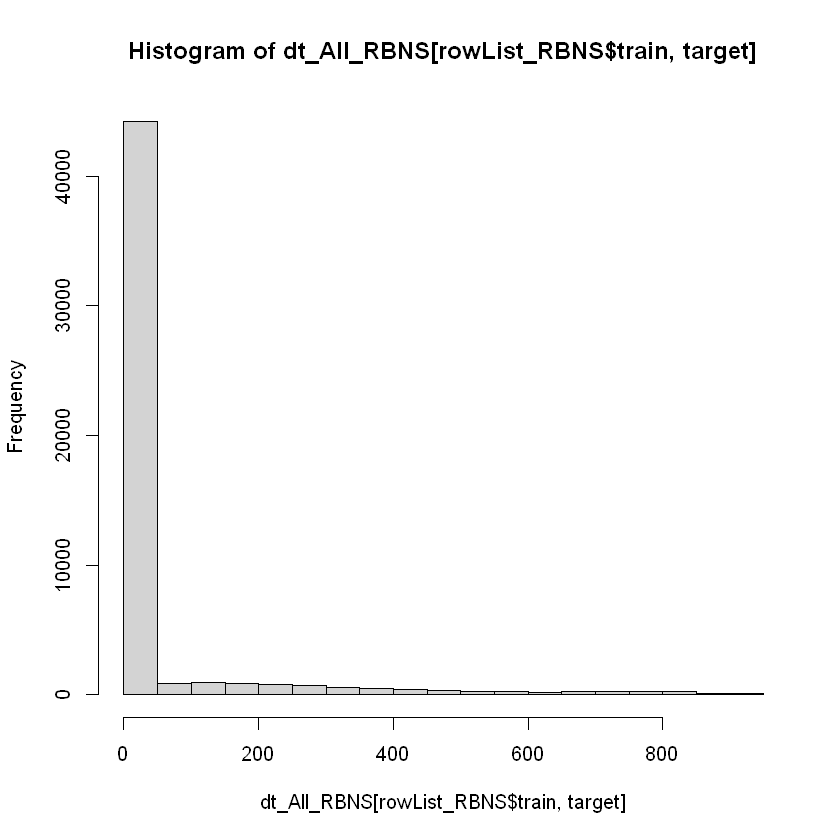

In [22]:
summary(dt_All_RBNS[rowList_RBNS$train, target])
hist(dt_All_RBNS[rowList_RBNS$train, target])

In [23]:
param <- list(
  objective = "reg:tweedie",
  max_depth = 2L,            # tree-depth
  subsample = 0.75,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,    # randomly sample columns before fitting each tree
  min.child.weight = 10,     # minimum weight per leaf
  eta = 0.1                  # Learning rate
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_RBNS_CV <- xgb.cv(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = 500,        # Maximum number of trees to build
  nfold = 5,
  early_stopping_rounds  = 10L,        # Stops algorithm early if performance has not improved in 
  print_every_n          = 10L,        # How often to print to console
  prediction             = TRUE        # Keeps the predictions
)

[1]	train-tweedie-nloglik@1.5:40.801670+0.271591	test-tweedie-nloglik@1.5:40.801578+1.156319 
Multiple eval metrics are present. Will use test_tweedie_nloglik@1.5 for early stopping.
Will train until test_tweedie_nloglik@1.5 hasn't improved in 10 rounds.

[11]	train-tweedie-nloglik@1.5:27.266881+0.173483	test-tweedie-nloglik@1.5:27.274072+0.615479 
[21]	train-tweedie-nloglik@1.5:24.275788+0.094509	test-tweedie-nloglik@1.5:24.300656+0.454288 
[31]	train-tweedie-nloglik@1.5:23.630472+0.077050	test-tweedie-nloglik@1.5:23.660613+0.384540 
[41]	train-tweedie-nloglik@1.5:23.429003+0.082236	test-tweedie-nloglik@1.5:23.489581+0.354651 
[51]	train-tweedie-nloglik@1.5:23.340812+0.082599	test-tweedie-nloglik@1.5:23.420178+0.351033 
[61]	train-tweedie-nloglik@1.5:23.298960+0.083714	test-tweedie-nloglik@1.5:23.388117+0.348643 
[71]	train-tweedie-nloglik@1.5:23.272636+0.084397	test-tweedie-nloglik@1.5:23.387241+0.367110 
[81]	train-tweedie-nloglik@1.5:23.255857+0.086599	test-tweedie-nloglik@1.5:23.3

In [24]:
dt_All_RBNS[rowList_RBNS$train, preds_oof := xgb_RBNS_CV$pred]

In [25]:
head(dt_All_RBNS)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,Price,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw,preds_oof
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200905040001,200801270002,8,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,397,0,1,4,12,451,1416859695,668,13905,0.0005107636
200905040001,200801270002,9,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,397,0,1,4,12,451,1416859695,668,13905,0.0014587329
200905040001,200801270002,10,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,397,0,1,4,12,451,1416859695,668,13905,0.0012024755
200905040001,200801270002,11,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,397,0,1,4,12,451,1416859695,668,13905,0.0006657771
200905200001,200801150002,7,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,...,837,0,1,5,23,468,1416859707,818,13893,0.0003094971
200905200001,200801150002,8,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,...,837,0,1,5,23,468,1416859707,818,13893,0.0013750661


In [26]:
# Fit the final model after cross-validation
xgb_RBNS_Fit <- xgb.train(
  params = param,
  data = xgb.RBNS_DMat.train,
  nrounds = xgb_RBNS_CV$best_iteration,
  watchlist = list(train = xgb.RBNS_DMat.train, test = xgb.RBNS_DMat.test),
  print_every_n = 10
)

# Make predictions on the test and all data
dt_All_RBNS[, preds_full := predict(xgb_RBNS_Fit, xgb.RBNS_DMat.all)]


[1]	train-tweedie-nloglik@1.5:40.796875	test-tweedie-nloglik@1.5:20.411248 
[11]	train-tweedie-nloglik@1.5:27.347296	test-tweedie-nloglik@1.5:13.704491 
[21]	train-tweedie-nloglik@1.5:24.332279	test-tweedie-nloglik@1.5:11.608979 
[31]	train-tweedie-nloglik@1.5:23.611791	test-tweedie-nloglik@1.5:10.721077 
[41]	train-tweedie-nloglik@1.5:23.422824	test-tweedie-nloglik@1.5:10.445035 
[51]	train-tweedie-nloglik@1.5:23.343053	test-tweedie-nloglik@1.5:10.321552 
[61]	train-tweedie-nloglik@1.5:23.301656	test-tweedie-nloglik@1.5:10.231375 
[71]	train-tweedie-nloglik@1.5:23.279997	test-tweedie-nloglik@1.5:10.207186 
[81]	train-tweedie-nloglik@1.5:23.263817	test-tweedie-nloglik@1.5:10.198902 


In [27]:
head(dt_All_RBNS)
tail(dt_All_RBNS)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw,preds_oof,preds_full
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<fct>,<fct>,...,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200905040001,200801270002,8,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,0,1,4,12,451,1416859695,668,13905,0.0005107636,0.0004199386
200905040001,200801270002,9,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,0,1,4,12,451,1416859695,668,13905,0.0014587329,0.0004199386
200905040001,200801270002,10,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,0,1,4,12,451,1416859695,668,13905,0.0012024755,0.0004199386
200905040001,200801270002,11,1,2008-01-27,2008-02-08,2009-05-04,2011-03-03,B,B,...,0,1,4,12,451,1416859695,668,13905,0.0006657771,0.0004199386
200905200001,200801150002,7,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,...,0,1,5,23,468,1416859707,818,13893,0.0003094971,0.0002904890
200905200001,200801150002,8,1,2008-01-15,2008-02-07,2009-05-20,2011-08-16,B,B,...,0,1,5,23,468,1416859707,818,13893,0.0013750661,0.0002904890


clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw,preds_oof,preds_full
<chr>,<chr>,<int>,<int>,<date>,<date>,<date>,<date>,<fct>,<fct>,...,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201811040010,201705130039,10,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,0,0,15,51,489,1416856301,667,17299,NA,0.000307628
201811040010,201705130039,11,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,0,0,15,51,489,1416856301,667,17299,NA,0.000307628
201811040010,201705130039,12,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,0,0,15,51,489,1416856301,667,17299,NA,0.000307628
201811040010,201705130039,13,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,0,0,15,51,489,1416856301,667,17299,NA,0.000307628
201811040010,201705130039,14,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,0,0,15,51,489,1416856301,667,17299,NA,0.000307628
201811040010,201705130039,15,1,2017-05-13,2017-07-03,2018-11-04,2020-09-01,BO,B,...,0,0,15,51,489,1416856301,667,17299,NA,0.000307628


In [28]:
names(dt_All_RBNS)

[1] "clm_number"     "pol_number"     "j"              "k"             
 [5] "date_pol_start" "date_occur"     "date_report"    "date_pay"      
 [9] "Cover"          "claim_type"     "Brand"          "Model"         
[13] "Price"          "target"         "flgTrain"       "Count"         
[17] "delay_uw_occ"   "delay_occ_rep"  "delay_uw_val"   "delay_rep_pay" 
[21] "date_uw"        "preds_oof"      "preds_full"

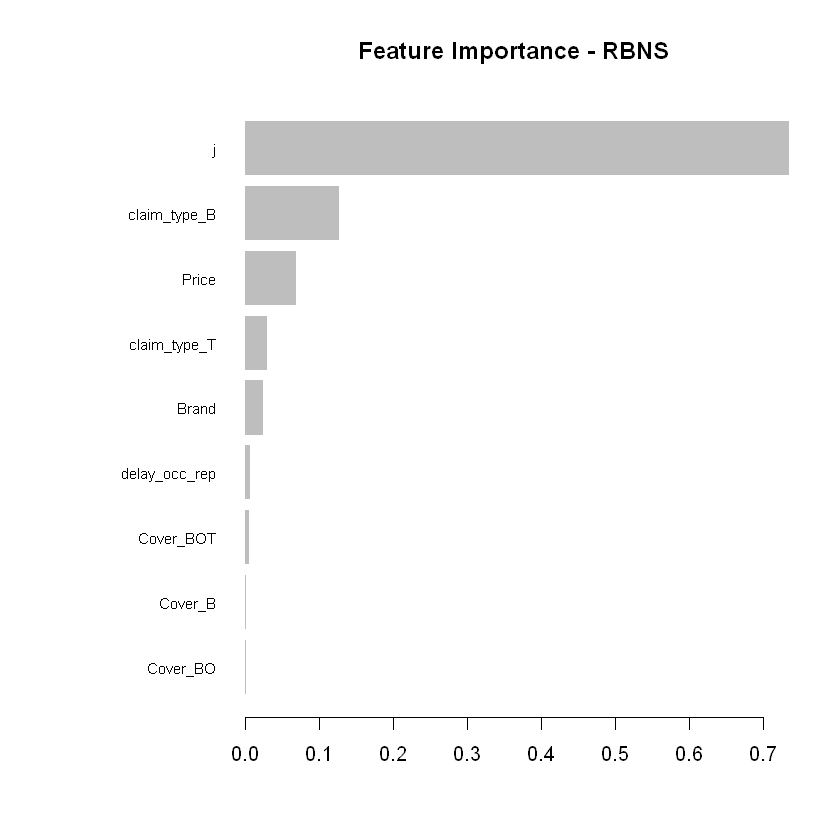

In [29]:
#default feature importance by gain
featImp_RBNS <- xgb.importance(xgb_RBNS_Fit, feature_names = colnames(xgb.RBNS_DMat.train))
xgb.plot.importance(featImp_RBNS, main="Feature Importance - RBNS")

In [30]:
# Assuming dt_All_RBNS contains the predicted values and original target values
# After the prediction is made, calculate the sum of Premium and Target (Loss) by year

# First, ensure that the data has the correct year format for policy start date
dt_All_RBNS[, year_start := year(date_pol_start)]  # Extract year from policy start date

# Sum the Premium (Price) and Target (Loss) for each year
dt_loss_ratio <- dt_All_RBNS[flgTrain == 1, .(
  Total_Premium = sum(Price, na.rm = TRUE),  # Sum of premium for the year
  Total_Loss = sum(target, na.rm = TRUE)  # Sum of target (claim cost) for the year
), by = year_start]

# Calculate the Loss Ratio per year
dt_loss_ratio[, Loss_Ratio := Total_Loss / Total_Premium]

# Use kable to display the results in a formatted tabl

# Print the result using kable
kable(dt_loss_ratio, "html", digits = c(0, 0, 0, 5),
      col.names = c("Year", "Total Premium", "Total Loss", "Loss Ratio"),
      format.args = list(big.mark = ",")) %>%
  kable_styling("striped") %>% 
  scroll_box(width = "100%") %>% 
  as.character() %>%
  display_html()


Year,Total Premium,Total Loss,Loss Ratio
"2,008","11,497,222","32,512",0.00283
"2,009","10,973,469","1,011,545",0.09218
"2,010","9,101,234","1,458,832",0.16029
"2,011","3,932,968","96,584",0.02456
"2,012","381,109",0,0.00000


In [31]:
# Assuming dt_All_RBNS contains the predicted values and original target values
# After the prediction is made, calculate the sum of Premium and Target (Loss) by year

# First, ensure that the data has the correct year format for policy start date
dt_All_RBNS[, year_start := year(date_pol_start)]  # Extract year from policy start date

# Sum the Premium (Price) and Target (Loss) for each year in the test data
dt_loss_ratio <- dt_All_RBNS[flgTrain == 0, .(
  Total_Premium = sum(Price, na.rm = TRUE),  # Sum of premium for the year
  Total_Loss = sum(target, na.rm = TRUE)  # Sum of target (claim cost) for the year
), by = year_start]

# Calculate the Loss Ratio per year
dt_loss_ratio[, Loss_Ratio := Total_Loss / Total_Premium]


# Print the result using kable
kable(dt_loss_ratio, "html", digits = c(0, 0, 0, 5),
      col.names = c("Year", "Total Premium", "Total Loss", "Loss Ratio"),
      format.args = list(big.mark = ",")) %>%
  kable_styling("striped") %>% 
  scroll_box(width = "100%") %>% 
  as.character() %>%
  display_html()


Year,Total Premium,Total Loss,Loss Ratio
"2,013","3,199,875","96,850",0.03027
"2,014","25,819,725","804,286",0.03115
"2,015","41,214,525","1,297,115",0.03147
"2,016","16,327,815","519,708",0.03183
"2,017","314,175","8,787",0.02797


In [59]:
# Ensure dt_All_RBNS contains the correct data including 'Price', 'preds_full', 'target', etc.

# Create the monthly aggregation
dt_RBNS_summary <- dt_All_RBNS[rowList_RBNS$test, .(preds = sum(preds_full), 
                                                     Price = sum(Price, na.rm = TRUE)), keyby = date_start_YYYYMM ]

# Extract the year from the 'date_start_YYYYMM' column and add it as a new column 'year'
dt_RBNS_summary[, year := substr(date_start_YYYYMM, 1, 4)]

# Aggregate data by year and sum preds and premium (Price)
dt_RBNS_yearly <- dt_RBNS_summary[, .(
  Total_Premium = sum(Price, na.rm = TRUE),  # Sum of premium for the year
  Total_Preds = sum(preds, na.rm = TRUE)     # Sum of predicted loss for the year
), by = year]

# Add a total row for the sum of all years
sumrow <- cbind(data.table(year = "Total"), dt_RBNS_yearly[, lapply(.SD, sum), .SDcols = c("Total_Premium", "Total_Preds")])

# Bind the sum row to the yearly data
dt_RBNS_yearly <- rbind(dt_RBNS_yearly, sumrow, fill = TRUE)

# Calculate the difference and percentage difference between predicted losses and total premium
dt_RBNS_yearly[, ':='(
  Diff = (Total_Preds),  # Difference between predicted loss and zero (since we removed target loss)
  Diff_pcnt = scales::percent(Total_Preds / Total_Premium, accuracy = 0.1),  # Percentage difference
  Pred_Loss_Ratio = ifelse(Total_Premium > 0, Total_Preds / Total_Premium, 0)  # Predicted loss ratio with a safe check for division by 0
)]

# Debugging: Check the values of Total_Premium and Total_Preds
print(dt_RBNS_yearly)

# Print the table as HTML with year-based aggregation
library(knitr)
library(kableExtra)

# Print the result using kable
kable(dt_RBNS_yearly, "html", 
      digits = c(0, 0, 0, 1, 5, 5),  # Display Loss Ratio up to 5 decimals
      col.names = c("Year", "Total Premium", "Predicted Loss", "Diff", "Diff (%)", "Predicted Loss Ratio"),  # Updated column names
      format.args = list(big.mark = ","), 
      escape = FALSE) %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()


     year Total_Premium Total_Preds        Diff Diff_pcnt Pred_Loss_Ratio
   <char>         <num>       <num>       <num>    <char>           <num>
1:   2013       3199875  103486.171  103486.171      3.2%      0.03234069
2:   2014      25819725  808185.689  808185.689      3.1%      0.03130110
3:   2015      41214525 1292288.625 1292288.625      3.1%      0.03135517
4:   2016      16327815  515153.186  515153.186      3.2%      0.03155065
5:   2017        314175    8759.338    8759.338      2.8%      0.02788044
6:  Total      86876115 2727873.009 2727873.009      3.1%      0.03139957


Year,Total Premium,Predicted Loss,Diff,Diff (%),Predicted Loss Ratio
2013,"3,199,875","103,486","103,486.2",3.2%,0.03234
2014,"25,819,725","808,186","808,185.7",3.1%,0.03130
2015,"41,214,525","1,292,289","1,292,288.6",3.1%,0.03136
2016,"16,327,815","515,153","515,153.2",3.2%,0.03155
2017,"314,175","8,759","8,759.3",2.8%,0.02788
Total,"86,876,115","2,727,873","2,727,873.0",3.1%,0.03140


In [36]:
names(dt_All_RBNS)

[1] "clm_number"        "pol_number"        "j"                
 [4] "k"                 "date_pol_start"    "date_occur"       
 [7] "date_report"       "date_pay"          "Cover"            
[10] "claim_type"        "Brand"             "Model"            
[13] "Price"             "target"            "flgTrain"         
[16] "Count"             "delay_uw_occ"      "delay_occ_rep"    
[19] "delay_uw_val"      "delay_rep_pay"     "date_uw"          
[22] "preds_oof"         "preds_full"        "year_start"       
[25] "date_start_YYYYMM"